In [18]:
import numpy as np
import os
import array
import pickle
from random import shuffle
from tqdm import tqdm  # Smart progress meter
import matplotlib.pyplot as plt
from PIL import Image
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
 
# Global Variables
TRAIN_DIR = 'C:/Users/Jamie/Dropbox/College/Year 4/Final Year Project/Python/CREPCHECK/TRAIN'
TEST_DIR = 'C:/Users/Jamie/Dropbox/College/Year 4/Final Year Project/Python/CREPCHECK/TEST'
IMG_SIZE = 52
NUM_CLASSES = 40

In [19]:
def encodeLabels(lbl):
    # sklearn's built-in function to encode the labels
    encoder  = LabelEncoder() 
    encoder.fit(lbl)
    encodedLabel = encoder.transform(lbl)
    oneHotEncoded = to_categorical(encodedLabel)
    return oneHotEncoded

In [20]:
labelsList = []

for file in tqdm(os.listdir(TRAIN_DIR)):
    # save the string before the underscore
    label = file.split('_')[0] 
    labelsList.append(label)
    
encodedLabel = encodeLabels(labelsList)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<?, ?it/s]


In [21]:
def CreateTrainingList():
    i = 0
    # create list to hold the image and label arrays for training
    trainList = [] 
    
    for file in tqdm(os.listdir(TRAIN_DIR)):
        # save the string before the underscore
        label = file.split('_')[0] 
        imgDir = os.path.join(TRAIN_DIR, label)
        
        for img in os.listdir(imgDir):
            path = os.path.join(imgDir, img)
            # Use PIL for image preprocessing
            img = Image.open(path) # Read image syntax
            img = img.convert('L') # Convert to grayscale
            # Set images to the same dimensions (52x52)
            img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS) 
            trainList.append([np.array(img), np.array(encodedLabel[i])])
        i = i+1
            
    shuffle(trainList)
    return trainList

In [22]:
def MakeTestList():
    testList = []
    i = 0 
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        imgNum = img.split('_')[1]  # get the number after the underscore just to give each image a unique id
        imgNum = imgNum.split('.')[0]
        
        img = Image.open(path)
        img = img.convert('L') # Convert to grayscale
        img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
        
        testList.append([np.array(img), encodedLabel[i]])
        if ((int(imgNum) % 10) == 0):
            i = i+1
    shuffle(testList)
    return testList

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 15.04it/s]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


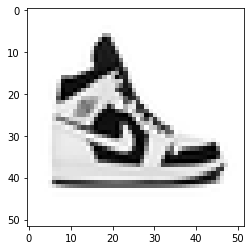

In [23]:
import tensorflow as tf
trainList = CreateTrainingList()
plt.imshow(trainList[1][0], cmap="gist_gray")
print(trainList[1][1])
plt.show()

In [24]:
from keras.preprocessing.image import ImageDataGenerator

X_train = []
Y_train = []

for features, label in trainList:
    X_train.append(features)
    Y_train.append(label)    
    
X_train = np.array(X_train).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y_train = np.array(Y_train)

image_gen = ImageDataGenerator(
    # Pixel normalization
    rescale=1./255, 
    # Rotate images by 90 degress
    rotation_range=90, 
    # Verticle & horizontal shifting
    width_shift_range=.1,
    height_shift_range=.1,
    # Brightness Augmentation
    brightness_range=[0.2,1.0],
    horizontal_flip=True)

# Apply the augmentation to the images from the dataset
image_gen.fit(X, augment=True)    

np.save('TrainImg_'+str(IMG_SIZE)+'_'+str(NUM_CLASSES)+'_grey.npy', X_train)
np.save('TrainLabel_'+str(IMG_SIZE)+'_'+str(NUM_CLASSES)+'_grey.npy', Y_train)

In [8]:
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Conv2D, Flatten, Activation, MaxPooling2D, Dropout
import numpy as np
import keras

# Load training data
TrainingImg = np.load('TrainImg_'+str(IMG_SIZE)+'_'+str(NUM_CLASSES)+'_grey.npy', allow_pickle=True)
TrainingLabel = np.load('TrainLabel_'+str(IMG_SIZE)+'_'+str(NUM_CLASSES)+'_grey.npy', allow_pickle=True)

model = Sequential()

model.add(Conv2D(128, kernel_size=(7, 7), activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,1)))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(256, (7, 7), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(NUM_CLASSES, activation='softmax'))

# Training the model
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

model.fit(TrainingImg, TrainingLabel, batch_size=240, epochs=40, validation_split=0.1)

Train on 2880 samples, validate on 320 samples
Epoch 1/40
2880/2880 [==============================] - 3s 918us/step - loss: 3.7041 - accuracy: 0.0285 - val_loss: 3.6798 - val_accuracy: 0.0719
Epoch 2/40
2880/2880 [==============================] - 1s 356us/step - loss: 3.6504 - accuracy: 0.0465 - val_loss: 3.5834 - val_accuracy: 0.0969
Epoch 3/40
2880/2880 [==============================] - 1s 410us/step - loss: 3.5007 - accuracy: 0.0920 - val_loss: 3.3303 - val_accuracy: 0.1594
Epoch 4/40
2880/2880 [==============================] - 1s 399us/step - loss: 3.2596 - accuracy: 0.1462 - val_loss: 3.0798 - val_accuracy: 0.2500
Epoch 5/40
2880/2880 [==============================] - 1s 390us/step - loss: 3.0078 - accuracy: 0.1976 - val_loss: 2.8263 - val_accuracy: 0.2531
Epoch 6/40
2880/2880 [==============================] - 1s 385us/step - loss: 2.7445 - accuracy: 0.2681 - val_loss: 2.6431 - val_accuracy: 0.3313
Epoch 7/40
2880/2880 [==============================] - 1s 399us/step - loss:

In [25]:
testList = MakeTestList()

X_test =[]
Y_test = []

for features, label in testList:
    X_test.append(features)
    Y_test.append(label)
    
X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y_test = np.array(Y_test)

100%|███████████████████████████████████████████████████████████████████████████████| 360/360 [00:00<00:00, 693.56it/s]


"\nplt.plot(['accuracy'], label='accuracy')\nplt.plot(['val_accuracy'], label = 'val_accuracy')\nplt.xlabel('Epoch')\nplt.ylabel('Accuracy')\nplt.ylim([0.5, 1])\nplt.legend(loc='lower right')\n\ntest_loss, test_acc = model.evaluate(X,  Y, verbose=2)"

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


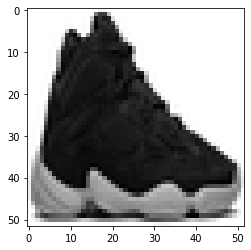

In [24]:
plt.imshow(trainList[132][0], cmap='gist_gray')
print(trainList[132][1])
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████| 360/360 [00:00<00:00, 719.35it/s]


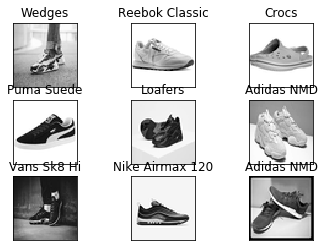

In [38]:
testList = MakeTestList()
fig = plt.figure()
ShoeList = ['Adidas Gazelle', 'Adidas NMD', 'Adidas Superstar', 'Adidas Ultra Boost 20', 'Alexander Mcqueen', 
              'Asics Gel Classic', 'Chelsea Boots', 'Converse', 'Converse High Tops', 'Crocs', 'Dr Martens', 
              'Fila Disruptor 2', 'High Heels', 'Hunter Wellies', 'Loafers', 'New Balance 220', 'New Balance 574', 
              'Nike Air Jordan 1', 'Nike Air Jordan 10', 'Nike Air Max 1', 'Nike Air Max 270', 'Nike Air Max 97', 
              'Nike Air VaporMax Flyknit 3', 'Nike Air VaporMax Plus', 'Nike Airforce 1', 'Nike Airmax 120', 
              'Nike React Element 55 SE', 'Nike SB', 'Old Skool Vans', 'Puma RS-X3', 'Puma Suede', 'Reebok Classic', 
              'Reebok Phase 1', 'Timberland Boots', 'Vans Era', 'Vans Sk8 Hi', 'Vans Slip-On', 
              'Wedges', 'Yeezy 500', 'Yeezy Boost 350']

for num, data in enumerate(testList[:9]):
    img_num = data[1]
    img_data = data[0]
    y = fig.add_subplot(3,3,num+1)
    orig = img_data
    new = img_data.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    prediction = model.predict(new)[0]
    
    guess = ShoeList[np.argmax(prediction)]
    
    y.imshow(orig, cmap="gist_gray")
    plt.title(guess)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [20]:
with open('CREPCHECK-65acc-52px-40shoes.pickle', 'wb') as f:
    pickle.dump(model, f)